In [89]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import datetime, warnings, scipy 
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict

from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings(action='once')
from geopandas import points_from_xy
import geopandas as gdp


    # OLS
import statsmodels.api as sm
    # ML Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [90]:

# ---------------   OLS    --------------------

def model_OLS_prix(data, outcome, features, summary = True) : 
    X = data[features]
    Y = data[outcome]

    X = sm.add_constant(X)

    model = sm.OLS(Y, X).fit()
    
    if summary : 
        print(model.summary())
    
    return(model)

def indice_prix_quarter(model_ols_prix, plot = True) : 
    indices = model_ols_prix.params[:15]
    indices = indices[0] + indices
    indices[0] = indices[0]/2
    index = indices.index[1:].insert(0, 'quarter_2017_Q3')
    indices.index = index
    indices

    indices_plot = indices.copy()
    indices_plot.index = indices_plot.index.str[8:12]+'-'+indices_plot.index.str[13:]
    indices_plot.index = pd.to_datetime(indices_plot.index)
    indices.index = indices.index.str[8:12]+'_'+indices.index.str[13:]
    
    if plot : 
        indices_plot.plot()
    
    return(indices)

def add_indice_prix(data_train, indices) :
    # Growth
    growth = indices.pct_change()
    growth[0] = 0
    
    growth_cum = growth.copy()
    growth_cum[1] = 1+growth_cum[1]
    for i in range(1,len(growth)-1) : 
        growth_cum[i+1] = (growth_cum[i])*(1+growth[i+1])
    growth_cum[0] = 1
    
    df_growth = pd.DataFrame(growth_cum).reset_index()
    df_growth.columns  = ['quarter', 'pct_change']
    
    df_growth['pct_change_toQ1_2021'] = df_growth.iloc[14,1]-df_growth['pct_change']
    
    # Merge with data
    data = data_train.copy()
    data = data.merge(df_growth, on = 'quarter', how = 'left')
    data['Prix_m2_actualise_Q1_2021'] = data['Prix_m2']*(1+data['pct_change_toQ1_2021'])
    
    return(data)

# -------------    KNN   ------------------ #

def model_KNN_coordinates(df_train, df_test, features,
                          label_train, label_test,
                          standardization, type_weights, max_nn, nb_cv) :
        # X datasets
    X_train_knn = df_train[features]
    X_test_knn = df_test[features]
        # outcomes
    y_train = df_train[label_train]
    y_test = df_test[label_test]

        # pipeline for the model
    pipe = Pipeline([('scaler', standardization), ('Knn', KNeighborsRegressor(weights=type_weights))])
    parameters = {'Knn__n_neighbors': range(1, max_nn, 2)} 
    knn_pipe = GridSearchCV(pipe, parameters, cv=nb_cv)
    knn_pipe.fit(X_train_knn, y_train)

    print('Returned hyperparameter: {}'.format(knn_pipe.best_params_))

    return(knn_pipe)

def model_RF_post_KNN(df_test, df_train, features_RF, features_KNN, label_train, label_test,
                      model_knn, standardisation, range_depth, nb_cv) :
    X_train_rf = df_train[features_RF]
    X_train_rf['y_pred_knn'] = model_knn.predict(df_train[features_KNN])
    X_test_rf = df_test[features_RF]
    X_test_rf['y_pred_knn'] = model_knn.predict(df_test[features_KNN])
        # outcomes
    y_train = df_train[label_train]
    y_test = df_test[label_test]

        # Model
    pipe = Pipeline([('scaler', standardisation), ('RForest', RandomForestRegressor())])
    parameters = {'RForest__max_depth': range_depth} # defining parameter space
    rforest_pipe = GridSearchCV(pipe, parameters, cv=nb_cv)
    rforest_pipe.fit(X_train_rf, y_train)

    return(rforest_pipe)


def features_importances(model_importances, X_train_model) :
    #X_train_model = df_train[features_model]
    indices = np.argsort(model_importances)[::-1]
    columns = X_train_model.columns
    # plot
    nb_features = X_train_model.shape[1]
    plt.figure(figsize=(15, 8))
    plt.title("Feature importances")
    plt.barh(
        range(nb_features),
        model_importances[indices],
        color='b')
    plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
    plt.show()
    
   

# -------------   SCORES   ---------------- #

def MAPE(Y_actual, Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def MDAPE(Y_actual, Y_Predicted):
    mdape = np.median(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mdape

def compute_scores(model, X_test, y_test) :
    y_pred = model.predict(X_test)

    mape = MAPE(y_test, y_pred)
    mdape = MDAPE(y_test, y_pred)
    
    print("MAPE: ", mape)
    print("MDAPE: ", mdape)


In [91]:
import pandas as pd
import numpy as np
import datetime, warnings, scipy 
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

def Process_data(data, quantile_low, quantile_high):    
    
    #we remove the extreme 5 % values of price per meter_square
    Threshold_up = data.groupby(['iris_code','quarter'])['Prix_m2'].quantile(quantile_high).reset_index()
    Threshold_down = data.groupby(['iris_code','quarter'])['Prix_m2'].quantile(quantile_low).reset_index()

    df_comune ={'iris_code':Threshold_up['iris_code'], 'Threshold_up_iris': Threshold_up['Prix_m2'] , 
            'Threshold_down_iris':Threshold_down['Prix_m2'] , 'quarter': Threshold_down['quarter']}
    df_comune = pd.DataFrame(df_comune)

    df_process = pd.merge(data, df_comune ,how='inner', on=['iris_code','quarter'])

    df_final = df_process[(df_process['Prix_m2'] < df_process['Threshold_up_iris']) 
                      & (df_process['Prix_m2'] > df_process['Threshold_down_iris'])]
    
    df_final=df_final.drop(['Threshold_up_iris','Threshold_down_iris'],axis = 1)
    
    return df_final

def Process_data_2(data):    
    
    #we remove the extreme 5 % values of price per meter_square
    data['Threshold_up'] = data['Pris_m2_moy_iris'] + data['std']
    data['Threshold_down'] = data['Pris_m2_moy_iris'] - data['std']


    df_final = data[(data['Prix_m2'] < data['Threshold_up']) 
                      & (data['Prix_m2'] > data['Threshold_down'])]
    
    df_final=df_final.drop(['Threshold_up','Threshold_down'],axis = 1)
    
    return df_final


# Mettre les variables de la liste_var en log dans le dataframe data
def log_var(data, liste_vars) : 
    for variable in liste_vars :
        new_variable = variable + '_log'
        data[new_variable] = np.log(data[variable])
        
    

# Filtre pour garder les données pertinentes pour le modèle
def filtre_data_pour_model(data, ville, type_local, quantile_low = None, quantile_high = None) :
    '''
    data : DataFrame (celui a nettoyer)
    ville : str ('Paris', 'Lyon', ...)
    type_local : int (1 : Maison / 2 : Appartement)
    quantile_low : int (\in [0, 1])
    quantile_high : int (\in [0, 1])
    output : DataFrame (nettoyé)
    '''
    data_model = data.copy()
    
    
    if quantile_low :
        min_prix = np.quantile(data.Prix_m2, quantile_low)
        data_model = data_model[data_model.Prix_m2 > min_prix]
    if quantile_high :
        max_prix = np.quantile(data.Prix_m2, quantile_high)
        data_model = data_model[data_model.Prix_m2 < max_prix]
        
    data_model = data_model[(data_model['bv2012_name'] == "['" + ville + "']")
                     & (data_model.code_type_local == type_local)]
    
    return(data_model)


def filter_quantile(data, var, quantile_low, quantile_high) :
    '''
    data : DataFrame (celui a nettoyer)
    ville : str ('Paris', 'Lyon', ...)
    type_local : int (1 : Maison / 2 : Appartement)
    quantile_low : int (\in [0, 1])
    quantile_high : int (\in [0, 1])
    output : DataFrame (nettoyé)
    '''
    data_model = data.copy()
    
    if quantile_low :
        min_prix = np.quantile(data[var], quantile_low)
        data_model = data_model[data_model[var] > min_prix]
    if quantile_high :
        max_prix = np.quantile(data[var], quantile_high)
        data_model = data_model[data_model[var] < max_prix]
    
    return(data_model)


# Premier split temporel avec toutes la bases de données,
# Les 20 derniers pourcent de la base sont dans l'éch de test
# Le reste sert d'apprentissage
def split_temporel_V1(data, liste_features, output) :
    '''
    data : DataFrame (sur lequel on veut faire le split
    liste_features : list (des variables explicatives)
    output : str
    output : 4 DataFrame (X_train, X_test, y_train, y_test)
    '''
    # Trier la base par date
    data = data.sort_values('date_mutation')

    # Choix les variables du modèles
    X = data[liste_features]
    y = data[output]
    
    # Shuffle = False pour garder les dernières obs en test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
    return(X_train, X_test, y_train, y_test)

    
#Split le dataset entre appartements et maisons
def split_appart_maison(data): 
    df_maison = data[data['code_type_local']==1]
    df_appart = data[data['code_type_local']==2]
    print(f"Nombre de maisons : {df_maison.shape[0]}")
    print(f"Nombre d'apparts : {df_appart.shape[0]}")
    return(df_maison, df_appart)


def zTransform (data, liste_vars, prix) : 
    scaler = StandardScaler()
    liste_vars.append(prix)
    scaler.fit(data[liste_vars])
    print(scaler.mean_)
    data[liste_vars] = scaler.transform(data[liste_vars])
    

def nb_iris (data, path, dep_code):
    IRIS = pd.read_excel(path, header = 5)[['CODE_IRIS', 'DEP']]
    IRIS_ville = IRIS[IRIS["DEP"] == dep_code]
    IRIS_ville = IRIS_ville['CODE_IRIS'].tolist()
    iris_df = data['iris_code'].unique().tolist()

    list_dif = [i for i in IRIS_ville + iris_df if i in IRIS_ville and i not in iris_df]
    print(f"Length of all Paris IRIS : {len(IRIS_ville)}")
    print(f"Length of IRIS in DF : {len(iris_df)}")
    print(f"Number of IRIS not in DF : {len(list_dif)}")
    

# Ajouter des indicatrices si la variable continue dépasse un seuil
def dummies_pr_var_continues(data, var, seuil) :
    '''
    data : DataFrame
    var : str
    seuil : int / float
    output : None
    '''
    var_dummy = var + '_dummy'
    data[var_dummy] = 0
    data.loc[data[var] > seuil, var_dummy] = 1
    
    
def filling_factor(data) : 
    '''
    Output : Table des pourcentages de remplissage des variables
    '''
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)']=(data.shape[0]-missing_df['missing values'])/data.shape[0]*100
    missing_df.sort_values('filling factor (%)').reset_index(drop = True)
    return(missing_df)


def calc_vif(X):
    '''
    Output : Table des VIF des variables
    '''
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)


<>:51: DeprecationWarning: invalid escape sequence \i


### Data

In [158]:
df = pd.read_csv('./df_Toulouse_appartement_vf.csv',low_memory=False)

In [159]:
dfm = pd.read_csv('./df_Toulouse_maison_vf.csv',low_memory=False)

In [160]:
list_dist_metro_dummies = []
for i in range(0,df.shape[0]):
    if df['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (df['dist_metro'].iloc[i] <= 500) & (df['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (df['dist_metro'].iloc[i] > 500) & (df['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
df['dist_metro_dummies'] = list_dist_metro_dummies

### OLS

In [162]:
#dummies_pr_var_continues(df, 'dist_metro', 200)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)

In [164]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [165]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [166]:
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-3
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

In [167]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [168]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     142.4
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:33:56   Log-Likelihood:            -1.6238e+05
No. Observations:               19709   AIC:                         3.248e+05
Df Residuals:                   19692   BIC:                         3.249e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

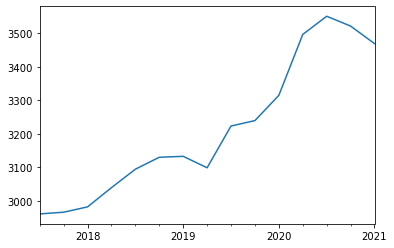

In [169]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

### KNN

In [170]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [171]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 23}


In [172]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  11.593018937862725
MDAPE:  9.174631173729322


In [173]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  12.101562365803579
MDAPE:  10.247081918815429


### RF

In [273]:
features_RF = [#'Nombre_dependance', 
               'Nombre_dependance', 'dist_metro',
               #'dist_metro', 
               'nombre_pieces_principales',
               #'Ec_elementaire', 'Ec_maternelle',
               'Ec_elementaire', 'Ec_maternelle',
               'N_apparts', 
               'DISP_MED19', 
               'Part_chomeurs', 
               #'P19_LOG','P19_RP_SDB','P19_RP_CCCOLL',
               #'P19_RP_CCIND','P19_RP_CINDELEC'
]

In [274]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [1, 1000], nb_cv = 5)

In [275]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  11.748786182123853
MDAPE:  9.826000319464448


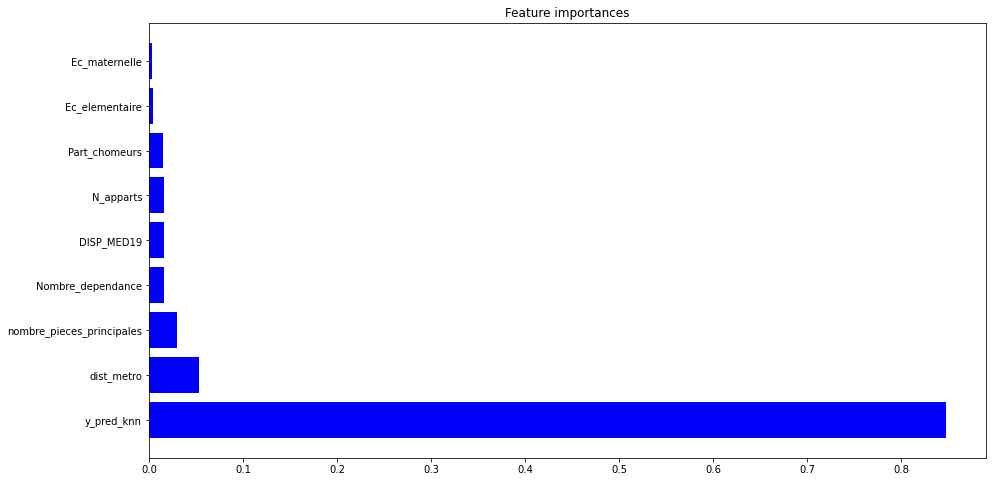

In [276]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

In [124]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150, 250, 500]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, df_train[label_train])

compute_scores(gboost_pipe, X_test_rf, df_test[label_test])

MAPE:  11.783811368110262
MDAPE:  9.895061662740455


### Maison

### OLS

In [200]:
#dummies_pr_var_continues(dfm, 'dist_metro', 0.01)
dummies_pr_var_continues(dfm, 'Nombre_dependance', 0)
dummies_pr_var_continues(dfm, 'Ec_maternelle', 0)
dummies_pr_var_continues(dfm, 'Ec_elementaire', 0)

df_train_m = dfm[dfm['date_mutation'] < '2021-04-01']
df_test_m = dfm[dfm['date_mutation'] >= '2021-04-01']

df_train_m = pd.concat([df_train_m, pd.get_dummies(df_train_m[['quarter']])], axis = 1)
df_train_m['n_pieces_BienStandard'] = df_train_m['nombre_pieces_principales']- 4 #4c'est le nombre le plus frequent
df_train_m['n_dependances_BienStandard'] = df_train_m['Nombre_dependance']

features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

list_dist_metro_dummies = []
for i in range(0,dfm.shape[0]):
    if dfm['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (dfm['dist_metro'].iloc[i] <= 500) & (dfm['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (dfm['dist_metro'].iloc[i] > 500) & (dfm['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
dfm['dist_metro_dummies'] = list_dist_metro_dummies


In [201]:
model_m = model_OLS_prix(df_train_m, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.966
Date:                Thu, 30 Mar 2023   Prob (F-statistic):           3.28e-10
Time:                        19:40:30   Log-Likelihood:                -19152.
No. Observations:                2336   AIC:                         3.834e+04
Df Residuals:                    2319   BIC:                         3.844e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

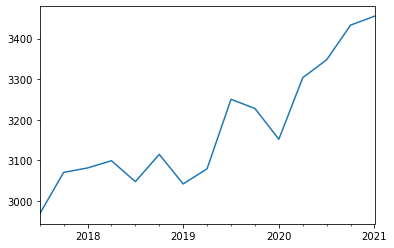

In [202]:
df_train_m = add_indice_prix(df_train_m, indice_prix_quarter(model_m, plot = True))

### KNN

In [225]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train_m  = 'Prix_m2_actualise_Q1_2021'
label_test_m   = 'Prix_m2'

knn_pipe_m = model_KNN_coordinates(df_train_m, df_test_m, features_knn,
                          label_train_m, label_test_m,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 9}


In [226]:

    # Scores on TRAIN dataset
compute_scores(knn_pipe_m, df_train_m[features_knn], df_train_m[label_train])

MAPE:  13.048844162218726
MDAPE:  9.664033631868419


In [227]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test_m[features_knn], df_test_m[label_test])

MAPE:  18.952746316437686
MDAPE:  17.24560040553687


### RF

In [269]:
features_RF_m = [#'Nombre_dependance', 
               'Nombre_dependance', 'dist_metro',
               #'dist_metro', 
               'nombre_pieces_principales',
               #'Ec_elementaire', 'Ec_maternelle',
               'Ec_elementaire_dummy', 'Ec_maternelle_dummy',
               'N_apparts', 
               'DISP_MED19', 
               'Part_chomeurs', 
               #'P19_LOG','P19_RP_SDB','P19_RP_CCCOLL',
               #'P19_RP_CCIND','P19_RP_CINDELEC'
]

In [270]:
RF_model_m = model_RF_post_KNN(df_test_m, df_train_m, features_RF_m, features_knn, label_train_m, label_test_m,
                      model_knn = knn_pipe_m, standardisation = StandardScaler(), range_depth = [1, 1000], nb_cv = 5)


In [271]:
X_train_rf_m = df_train_m[features_RF_m]
X_train_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_train_m[features_knn])
X_test_rf_m = df_test_m[features_RF_m]
X_test_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_test_m[features_knn])
compute_scores(RF_model_m, X_test_rf_m, df_test_m[label_test_m])

MAPE:  14.531278046633242
MDAPE:  11.332700487226004


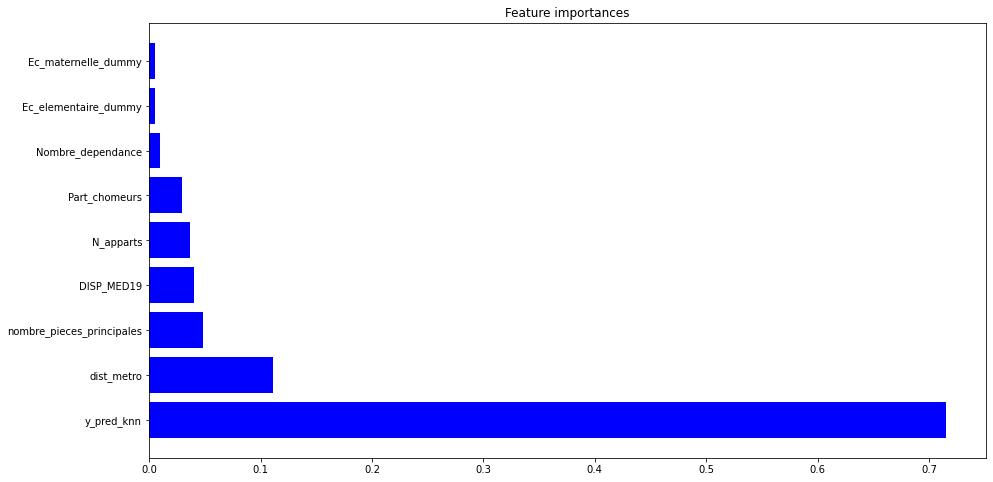

In [277]:
RF_importances_m = RF_model_m.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances_m, X_train_rf_m)